In [400]:
import func.task1 as t1

import copy, pickle, itertools

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import skimage.io as skio
import skimage.transform as sktr
import skimage.color as skcol

import skimage.util as skut
import skimage.filters as skfl

from sklearn.svm import SVC
import sklearn.model_selection as le_ms
import sklearn.preprocessing as le_pr
import sklearn.linear_model as le_lm
import sklearn.metrics as le_me

import tensorflow.keras.applications.inception_v3 as ki3
import tensorflow.keras.applications.resnet50 as k50

from importlib import reload
reload(t1)
from tqdm.notebook import tqdm

import yaml

%matplotlib inline

# About
Cardiomegaly: enlargement of the heart

This notebook shows the various data pipelines used to generate machine learning models to best predict the presence of cardiomegaly in the given dataset of patients.

Pre-processing techniques such as cropping and contrast stretching were first implemented. Transfer learning techniques were used by using models such InceptionV3, ResNet50 and VGG16. The resulting feature matrices were then used to train classifiers such Logistic Regression and Support Vector Machines. The resulting models's metrics such ROC AUC and F-1 scores were then compared. They were then used to compare the efficiency of the models in comparing training and testing data (to see if there is overfitting).

In [409]:
code_obj = t1.Task1()

In [410]:
with open("func/params.yaml", "r") as f:
    dict_params = yaml.full_load(f)["task1"]

dict_params

{'crop': {'n_rows': 8,
  'n_cols': 8,
  'range_rows': [1, 7],
  'range_cols': [4, 7]},
 'crop_new': {'n_rows': 9,
  'n_cols': 9,
  'range_rows': [2, 8],
  'range_cols': [1, 9]},
 'transfer_learning': {'ResNet50': {'new_img_dims': [224, 224],
   'to_rgb': True},
  'InceptionV3': {'new_img_dims': [299, 299], 'to_rgb': True},
  'VGG16': {'new_img_dims': [150, 150], 'to_rgb': True}},
 'classification': {'LogisticRegression': {'penalty': 'l1',
   'C': 0.5,
   'solver': 'liblinear'},
  'SVM': {'C': 0.5, 'kernel': 'rbf', 'probability': True}}}

## Loading information about the dataset

In [411]:
df_info = pd.read_csv("dataset/dataInfo.csv", index_col=False)
df_info["filepath"] = df_info["FullFileName"].apply(lambda path: os.path.join("dataset", path))
df_info

,imgID,FileName,Cardiomegaly,Train,Findings,PatAge,PatGender,ViewPos,OrigWidth,OrigHeight,OrigPixSpacingX,OrigPixSpacingY,FullFileName,filepath
0,0,00000001_000.png,1,1,Cardiomegaly,058Y,M,PA,2682,2749,0.143,0.143,train/00000001_000.png,dataset/train/00000001_000.png
1,3,00000002_000.png,0,1,No Finding,081Y,M,PA,2500,2048,0.171,0.171,train/00000002_000.png,dataset/train/00000002_000.png
2,13,00000005_000.png,0,1,No Finding,069Y,F,PA,2048,2500,0.168,0.168,train/00000005_000.png,dataset/train/00000005_000.png
3,21,00000006_000.png,0,1,No Finding,081Y,M,PA,2500,2048,0.168,0.168,train/00000006_000.png,dataset/train/00000006_000.png
4,22,00000007_000.png,0,1,No Finding,082Y,M,PA,2500,2048,0.168,0.168,train/00000007_000.png,dataset/train/00000007_000.png
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21961,112114,00030801_000.png,0,1,No Finding,039Y,M,PA,2500,2048,0.168,0.168,train/00030801_000.png,dataset/train/00030801_000.png
21962,112116,00030802_000.png,0,1,No Finding,029Y,M,PA,2048,2500,0.168,0.168,train/00030802_000.png,dataset/train/00030802_000.png
21963,112117,00030803_000.png,0,1,No Finding,042Y,F,PA,2048,2500,0.168,0.168,train/00030803_000.png,dataset/train/00030803_000.png
21964,112118,00030804_000.png,0,1,No Finding,030Y,F,PA,2048,2500,0.168,0.168,train/00030804_000.png,dataset/train/00030804_000.png


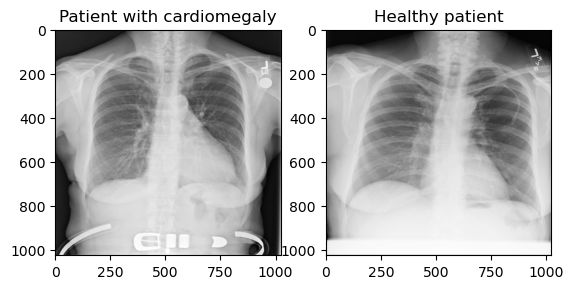

In [414]:
filepath_test_case = df_info[df_info["Cardiomegaly"] == 1].iloc[1]["filepath"]
filepath_test_control = df_info[df_info["Cardiomegaly"] == 0].iloc[1]["filepath"]
fig, axes = plt.subplots(1, 2)
axes[0].imshow(skio.imread(filepath_test_case), cmap="gray")
axes[0].title.set_text("Patient with cardiomegaly")
axes[1].imshow(skio.imread(filepath_test_control), cmap="gray");
axes[1].title.set_text("Healthy patient")

## Cropping images

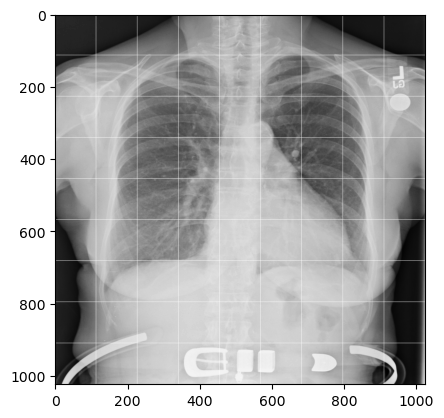

In [417]:
img_regions = code_obj.draw_regions(filepath_test_case, n_rows=9, n_cols=9)
plt.imshow(img_regions, cmap="gray")

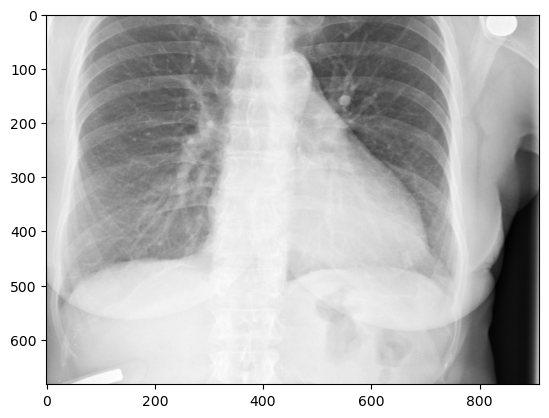

In [418]:
img_cropped = code_obj.crop_img_by_region(filepath_test_case, n_rows=9, n_cols=9, range_rows=(2, 8), range_cols=(1, 9))
plt.imshow(img_cropped, cmap="gray")

## Histogram stretching

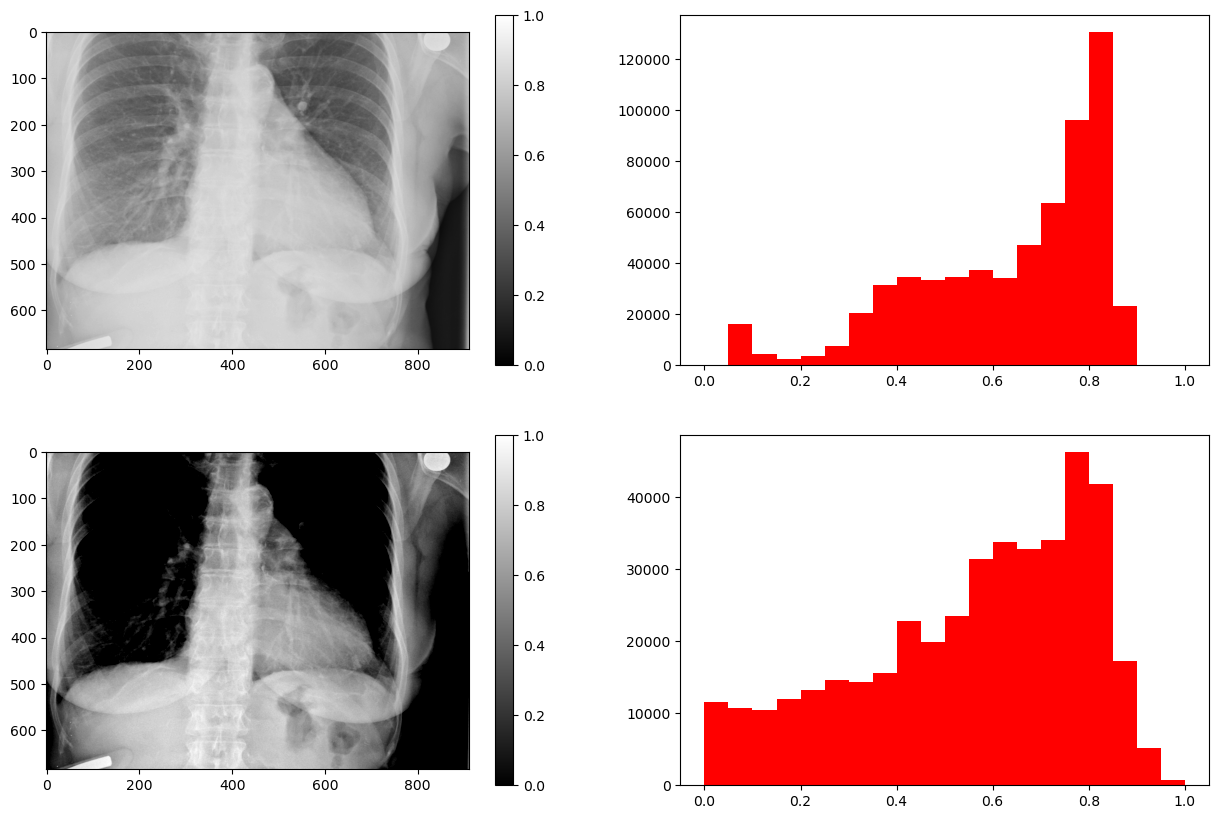

In [422]:
fig, axes = plt.subplots(2, 2)
fig.set_figheight(10)
fig.set_figwidth(15)
img_cropped_stretched = code_obj.contrast_stretch(img_cropped, lowest_pixel="otsu")
list_img = [img_cropped, img_cropped_stretched]

for i in [0, 1]:
    disp = axes[i, 0].imshow(list_img[i], cmap="gray", vmin=0, vmax=1)
    axes[i, 1].hist(list_img[i].flatten(), bins=20, range=(0, 1))
    plt.colorbar(disp, ax=axes[i, 0])

## Pipeline 1
1. Crop region of interest
2. Perform contrast stretching
3. Convert image to Inception V3 format
4. Save image
5. Create feature matrix
6. Run Logistic Regression
7. Run evaluation
8. Draw ROC curve

((299, 299), (683, 911))

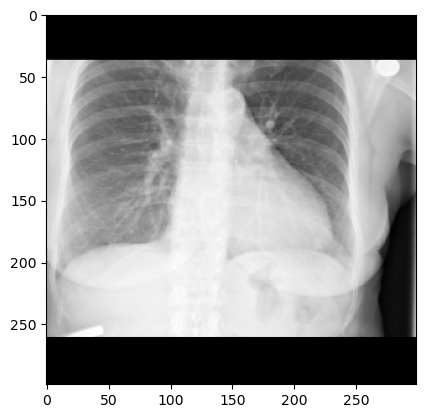

In [419]:
img_rescaled = code_obj.transform_img_to_size(img_cropped_stretched, (299, 299), to_rgb=False)
plt.imshow(img_rescaled, cmap="gray")
img_rescaled.shape, img_cropped_stretched.shape

## Pipeline 2
1. Crop region of interest
2. Perform contrast stretching
3. Convert image to ResNet50 format
4. Save image
5. Create feature matrix
6. Run Logistic Regression
7. Run evaluation
8. Draw ROC curve

((224, 224, 3), (683, 911))

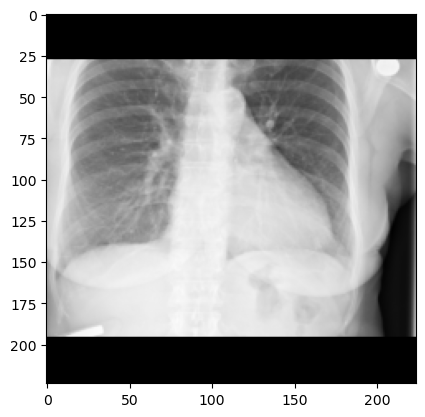

In [420]:
img_rescaled_r50 = code_obj.transform_img_to_size(img_cropped_stretched, (224, 224), to_rgb=True)
plt.imshow(img_rescaled_r50)
img_rescaled_r50.shape, img_cropped_stretched.shape

## Pipeline 3
1. Crop region of interest
2. Perform contrast stretching
3. Convert image to VGG16 format
4. Save image
5. Create feature matrix
6. Run Logistic Regression
7. Run evaluation
8. Draw ROC curve

((150, 150, 3), (683, 911))

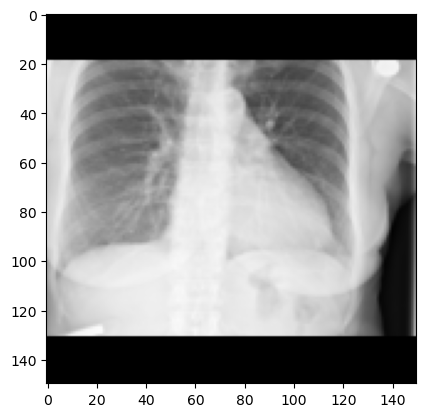

In [421]:
img_rescaled_vgg16 = code_obj.transform_img_to_size(img_cropped_stretched, (150, 150), to_rgb=True)
plt.imshow(img_rescaled_vgg16)
img_rescaled_vgg16.shape, img_cropped_stretched.shape

## Pipeline 4
1. Crop region of interest
2. Perform contrast stretching
3. Convert image to InceptionV3 format
4. Save image
5. Create feature matrix
6. Run SVM
7. Run evaluation
8. Draw ROC curve

## Pipeline 5
1. Crop region of interest
2. Perform contrast stretching
3. Convert image to ResNet50 format
4. Save image
5. Create feature matrix
6. Run SVM
7. Run evaluation
8. Draw ROC curve

## Pipeline 6
1. Crop region of interest
2. Perform contrast stretching
3. Convert image to VGG16 format
4. Save image
5. Create feature matrix
6. Run SVM
7. Run evaluation
8. Draw ROC curve

## Pipeline 7:
1. Crop region of interest
2. Perform contrast stretching
3. Convert image to Inception V3 format
4. Save image
5. Create feature matrix
6. Perform cross-validation (with ~ 1:1 class population)
7. Run evaluation
8. Draw ROC curve

## Pipeline 8:
1. Crop region of interest
2. Perform contrast stretching
3. Convert image to ResNet50 format
4. Save image
5. Create feature matrix
6. Perform cross-validation (with ~ 1:1 class population)
7. Run evaluation
8. Draw ROC curve

## Pipeline 9: 
1. Crop region of interest (new)
2. Perform contrast stretching
3. Convert image to Inception V3 format
4. Save image
5. Create feature matrix
6. Run Logistic Regression
7. Run evaluation
8. Draw ROC curve

## Pipeline 10
1. Crop region of interest (new)
2. Perform contrast stretching
3. Convert image to ResNet50 format
4. Save image
5. Create feature matrix
6. Run Logistic Regression
7. Run evaluation
8. Draw ROC curve

## Pre-processing images and saving them as .npy files

In [397]:
# trainXInceptionV3, trainYInceptionV3, testXInceptionV3, testYInceptionV3 = code_obj.preprocess_images(transfer_learning_model="InceptionV3")
# trainXResNet50, trainYResNet50, testXResNet50, testYResNet50 = code_obj.preprocess_images(transfer_learning_model="ResNet50")
# trainXVGG16, trainYVGG16, testXVGG16, testYVGG16 = code_obj.preprocess_images(transfer_learning_model="VGG16")

# trainXInceptionV3_v2, trainYInceptionV3_v2, testXInceptionV3_v2, testYInceptionV3_v2 = code_obj.preprocess_images(transfer_learning_model="InceptionV3", crop="v2")
# trainXResNet50_v2, trainYResNet50_v2, testXResNet50_v2, testYResNet50_v2 = code_obj.preprocess_images(transfer_learning_model="ResNet50", crop="v2")


  0%|          | 0/21966 [00:00<?, ?it/s]

2022-12-03 21:32:44.726838: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-03 21:32:44.739635: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 4. Tune using inter_op_parallelism_threads for best performance.


  0%|          | 0/21966 [00:00<?, ?it/s]

In [398]:
# for trainX, trainY, testX, testY, tl_model_type in [[trainXInceptionV3, trainYInceptionV3, testXInceptionV3, testYInceptionV3, "InceptionV3"], [trainXResNet50, trainYResNet50, testXResNet50, testYResNet50, "ResNet50"], [trainXVGG16, trainYVGG16, testXVGG16, testYVGG16, "VGG16"]]:
#     np.save(os.path.join("dataset", f"_trainX_{tl_model_type}.npy"), trainX)
#     np.save(os.path.join("dataset", f"_trainY_{tl_model_type}.npy"), trainY)
#     np.save(os.path.join("dataset", f"_testX_{tl_model_type}.npy"), testX)
#     np.save(os.path.join("dataset", f"_testY_{tl_model_type}.npy"), testY)

# for trainX, trainY, testX, testY, tl_model_type in [[trainXInceptionV3_v2, trainYInceptionV3_v2, testXInceptionV3_v2, testYInceptionV3_v2, "InceptionV3_v2"], [trainXResNet50_v2, trainYResNet50_v2, testXResNet50_v2, testYResNet50_v2, "ResNet50_v2"]]:
#     np.save(os.path.join("dataset", f"_trainX_{tl_model_type}.npy"), trainX)
#     np.save(os.path.join("dataset", f"_trainY_{tl_model_type}.npy"), trainY)
#     np.save(os.path.join("dataset", f"_testX_{tl_model_type}.npy"), testX)
#     np.save(os.path.join("dataset", f"_testY_{tl_model_type}.npy"), testY)

### The pipelines were run, and their corresponding results were saved.
The pipeline files are named task1_pipeline[X].py


## Loading results

### What is version 2?
The first pipelines (all except version 2) were done by dividing the original image into 8x8 grid and then cropping the region [1, 7] and [4, 7]. New cropping criteria were applied to only the best performing older pipelines (InceptionV3 & Logistic Regression, and ResNet50 and Logistic Regression) with parameters of 9x9 grid and [2, 8] and [1, 9]. It turns out, these new pipelines gave even better results.

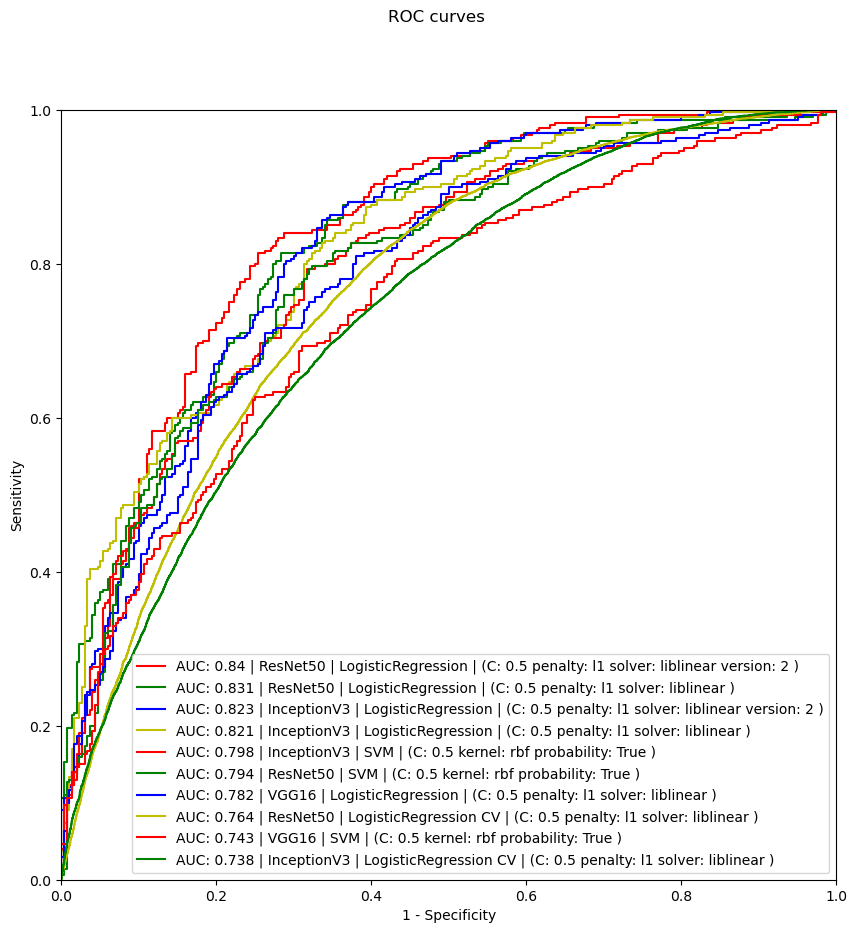

In [423]:
fig = code_obj.load_plot_roc()
fig.savefig("all_roc.png")

## Compare performance
Here, I compare the performance of every model on each image. Image-wise comparison is done, which is then used to compare performance amongst each patient group (age, gender and view position).

df_group: Element-wise performance<br/>
df_summary: Summary of all the generated models

In [437]:
df_summary, df_group = code_obj.generate_model_performance_summary()
df_summary["uid"] = df_summary["uid"].astype("str")
df_summary.to_csv("df_summary.csv", float_format="%f", index=None)
df_group.to_csv("df_group.csv", float_format="%f", index=None)

In [440]:
df_group

,true,pred,age,gender,view_pos,train,model
0,1,True,058Y,M,PA,1,InceptionV3_LogisticRegression CV
1,0,False,081Y,M,PA,1,InceptionV3_LogisticRegression CV
2,0,True,069Y,F,PA,1,InceptionV3_LogisticRegression CV
3,0,True,081Y,M,PA,1,InceptionV3_LogisticRegression CV
4,0,False,082Y,M,PA,1,InceptionV3_LogisticRegression CV
...,...,...,...,...,...,...,...
595,0,False,042Y,F,PA,0,InceptionV3_v2_LogisticRegression
596,1,False,012Y,M,PA,0,InceptionV3_v2_LogisticRegression
597,0,True,042Y,F,PA,0,InceptionV3_v2_LogisticRegression
598,1,False,068Y,F,PA,0,InceptionV3_v2_LogisticRegression


In [441]:
df_summary

,uid,transfer_learning_type,model_type,train.threshold,train.f1,train.auc,test.threshold,test.f1,test.auc,unique_type
0,1668880622.000624,InceptionV3,LogisticRegression CV,0.864340,0.069427,0.672730,0.580378,0.636977,0.737711,InceptionV3 | LogisticRegression CV
1,1668762267.001495,ResNet50,SVM,0.042589,0.934899,0.990988,0.022467,0.740620,0.793567,ResNet50 | SVM
2,1668762205.355088,InceptionV3,SVM,0.053291,0.997854,0.999546,0.017511,0.750000,0.798044,InceptionV3 | SVM
3,1668762282.403145,VGG16,SVM,0.039617,0.954248,0.990468,0.024681,0.690000,0.742589,VGG16 | SVM
4,1670073729.005334,ResNet50_v2,LogisticRegression,0.071546,0.051530,0.583723,0.013097,0.643289,0.839711,ResNet50_v2 | LogisticRegression
5,1668532184.529656,VGG16,LogisticRegression,0.022514,0.154713,0.895247,0.018453,0.717428,0.782256,VGG16 | LogisticRegression
6,1668302823.934276,InceptionV3,LogisticRegression,0.029279,0.183285,0.926540,0.013103,0.759375,0.820889,InceptionV3 | LogisticRegression
7,1668454605.337763,ResNet50,LogisticRegression,0.036196,0.223339,0.936347,0.012171,0.773885,0.831233,ResNet50 | LogisticRegression
8,1668880311.938975,ResNet50,LogisticRegression CV,0.963258,0.073019,0.668327,0.487795,0.671736,0.764297,ResNet50 | LogisticRegression CV
9,1670073709.022864,InceptionV3_v2,LogisticRegression,0.009492,0.064306,0.672800,0.009550,0.646400,0.822933,InceptionV3_v2 | LogisticRegression


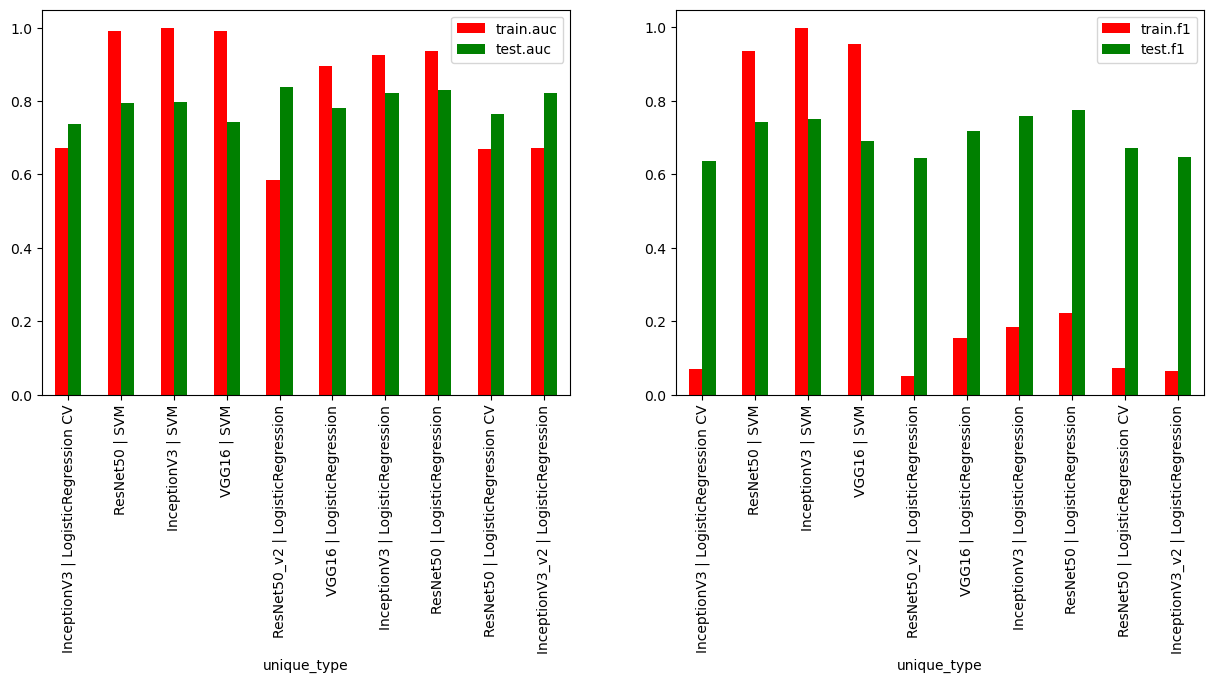

In [443]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
df_summary.plot.bar(x="unique_type", y=["train.auc", "test.auc"], ax=axes[0])
df_summary.plot.bar(x="unique_type", y=["train.f1", "test.f1"], ax=axes[1]);

In [405]:
df_group["pred"] = df_group["pred"].apply(lambda val: 1 if val else 0)
df_group["age"] = df_group["age"].apply(lambda val: int(val[:-1]))
# df_group["accurate"] = df_group.apply(lambda row: True if row["true"] == row["pred"] else False, axis=1)
bins_age = [0, 10, 30, 40,50, 60, 80, 100, 450]
df_group["age_binned"] = pd.cut(df_group["age"], bins_age)
def confusion(row):
    true = row["true"]
    pred = row["pred"]
    cf = ["F", "N"]
    if true == pred:
        cf[0] = "T"
    if true == 1:
        cf[1] = "P"
    row["cf"] = "".join(cf)
    return row

df_group = df_group.apply(confusion, axis=1)
df_group

,true,pred,age,gender,view_pos,train,model,age_binned,cf
0,1,1,58,M,PA,1,InceptionV3_LogisticRegression CV,"(50, 60]",TP
1,0,0,81,M,PA,1,InceptionV3_LogisticRegression CV,"(80, 100]",TN
2,0,1,69,F,PA,1,InceptionV3_LogisticRegression CV,"(60, 80]",FN
3,0,1,81,M,PA,1,InceptionV3_LogisticRegression CV,"(80, 100]",FN
4,0,0,82,M,PA,1,InceptionV3_LogisticRegression CV,"(80, 100]",TN
...,...,...,...,...,...,...,...,...,...
595,0,0,42,F,PA,0,InceptionV3_v2_LogisticRegression,"(40, 50]",TN
596,1,0,12,M,PA,0,InceptionV3_v2_LogisticRegression,"(10, 30]",FP
597,0,1,42,F,PA,0,InceptionV3_v2_LogisticRegression,"(40, 50]",FN
598,1,0,68,F,PA,0,InceptionV3_v2_LogisticRegression,"(60, 80]",FP


In [406]:
code_obj.per_group_performance(df_group)
# Find the results in model_bias.txt



==================InceptionV3_LogisticRegression CV==================
+----+------------+---------+------+------+------+------+-------------+----------+----------+
|    | view_pos   |   train |   FN |   FP |   TN |   TP |   precision |   recall |       f1 |
|----+------------+---------+------+------+------+------+-------------+----------+----------|
|  0 | AP         |       0 |   38 |    4 |   33 |   29 |    0.878788 | 0.432836 | 0.58     |
|  1 | PA         |       0 |  396 |   69 |  409 |  222 |    0.762887 | 0.359223 | 0.488449 |
+----+------------+---------+------+------+------+------+-------------+----------+----------+


+----+------------+---------+------+------+-------+------+-------------+-----------+----------+
|    | view_pos   |   train |   FN |   FP |    TN |   TP |   precision |    recall |       f1 |
|----+------------+---------+------+------+-------+------+-------------+-----------+----------|
|  0 | AP         |       1 | 1090 |   16 |  1142 |   71 |    0.816092 | 0